最近看了一下google的<a href="https://developers.google.com/machine-learning/crash-course/">机器学习速成课程</a>,其中有一个预测房价的例子,我觉得挺有意思，我之前也写过一篇预测房价的博客，但是google的这个例子中他们的特征工程做的比较细致，这其中有很多值得学习的地方，所以我想和大家分享一下,只不过这个例子的代码是用tensorflow写的，看起来有点费劲，我想把它简化一下,只用python和sklearn来实现原来的那些特征工程。

# 数据

我们可以在这里
<a href="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv">下载</a>美国加州的区域房价数据,我们首先看一下数据的字段:

* longitude：经度
* latitude ：维度
* housing_median_age ：房龄的中位数
* total_rooms ： 房间总数
* total_bedrooms ：卧室总数
* population ： 人口数量
* households ： 住户数量
* median_income ： 收入的中位数
* median_house_value ： 房价的中位数 (目标变量)  

这里总共有9个字段，其中median_house_value可以作为我们的目标变量,即需要预测的变量,其余的变量当作特征变量。这里的特别之处在于，这里的特征变量不是某套房子的特征变量，而是房子所在区域(经纬度)的特征变量,我们要根据区域的特征变量来预测该区域房价的中位数。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
# df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
df = pd.read_csv("./data/california_housing_train.csv", sep=",")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
5,-114.58,33.63,29.0,1387.0,236.0,671.0,239.0,3.3438,74000.0
6,-114.58,33.61,25.0,2907.0,680.0,1841.0,633.0,2.6768,82400.0
7,-114.59,34.83,41.0,812.0,168.0,375.0,158.0,1.7083,48500.0
8,-114.59,33.61,34.0,4789.0,1175.0,3134.0,1056.0,2.1782,58400.0
9,-114.60,34.83,46.0,1497.0,309.0,787.0,271.0,2.1908,48100.0


### 初步预测

我们在没有做特征工程之前，使用原始特征变量对模型(XGBoost)进行训练，并且使用XGBoost的默认参数设置，看一下模型的表现。首先我们创建训练集和测试集,然后进行预测:

In [3]:
X = df.loc[:, df.columns !=  'median_house_value'] 
y = df.loc[:, df.columns == 'median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train=y_train/1000
y_test=y_test/1000

In [4]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.7101865766340139
Test r2 score:  0.7784554684523863
Train RMSE: 52.5354
Test RMSE: 54.1574


这个结果已经比google课程中使用的tensorflow的模型表现要好很多，课程中的的模型做了特征工程以后的RMSE为79.03

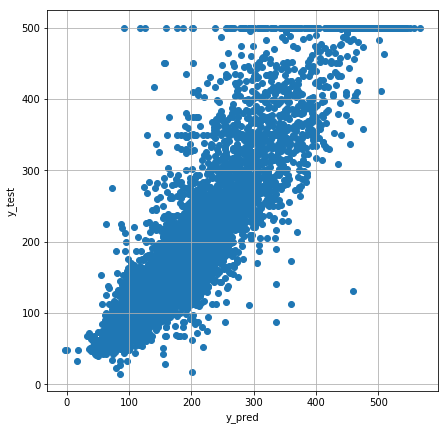

In [5]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.ylabel("y_test")
plt.xlabel("y_pred")
plt.scatter(y_pred1, y_test)

# 特征工程

我们在做特征工程时需要对所有特征变量进行仔细的研究,有些特征变量可能需要进行组合，有些特征变量需要进行分解，我们可能需要在原有的8个特征变量的基础上再扩展出多个特征变量。不过在此之前我们先要查看一下这些特征变量的数据分布情况,我们主要通过直方图或者柱状图来查看数据的分布情况。

首先我们来详细了解一下 latitude 和 longitude 这两个特征。它们是相关城市街区的地理坐标。利用这两个特征可以提供出色的可视化结果 - 我们来绘制 latitude 和 longitude 的曲线图，然后用颜色标注 median_house_value。

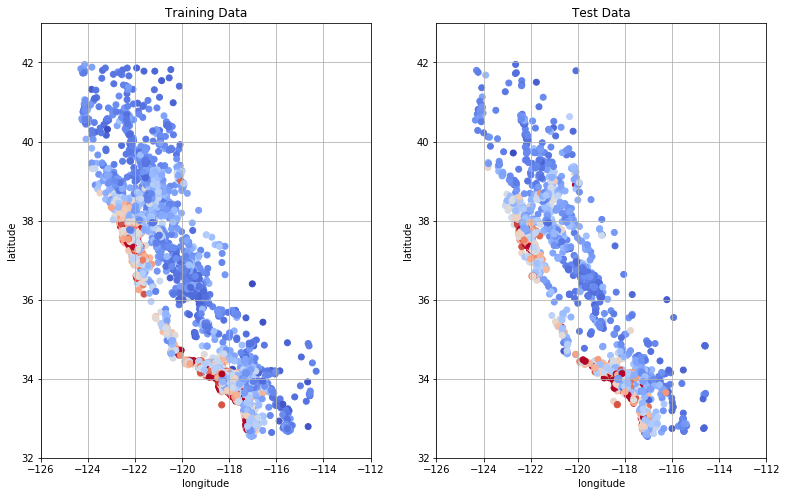

In [6]:
plt.figure(figsize=(13, 8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.grid()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(X_train["longitude"],
            X_train["latitude"],
            cmap="coolwarm",
            c=y_train["median_house_value"] / y_train["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Test Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.grid()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(X_test["longitude"],
            X_test["latitude"],
            cmap="coolwarm",
            c=y_test["median_house_value"] / y_test["median_house_value"].max())

_ = plt.plot()

我们可以看到散点图所呈现出的形状和加州的地图非常相似:

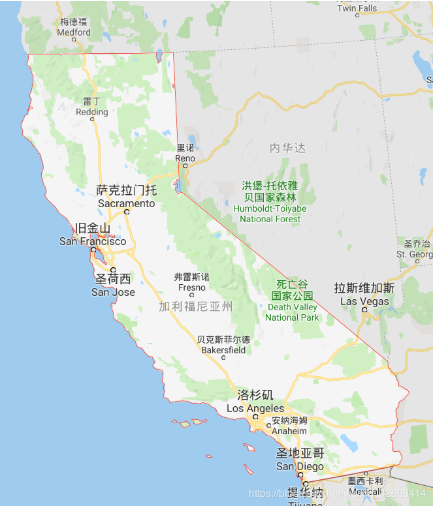





从散点图中我们看到房价中位数较高的区域主要集中在加州的西海岸地区(深红色),高房价主要集中在旧金山和洛杉矶这两个城市及其周边。

下面我们创建相关系数矩阵热力图来查看特征变量之间的相关性:

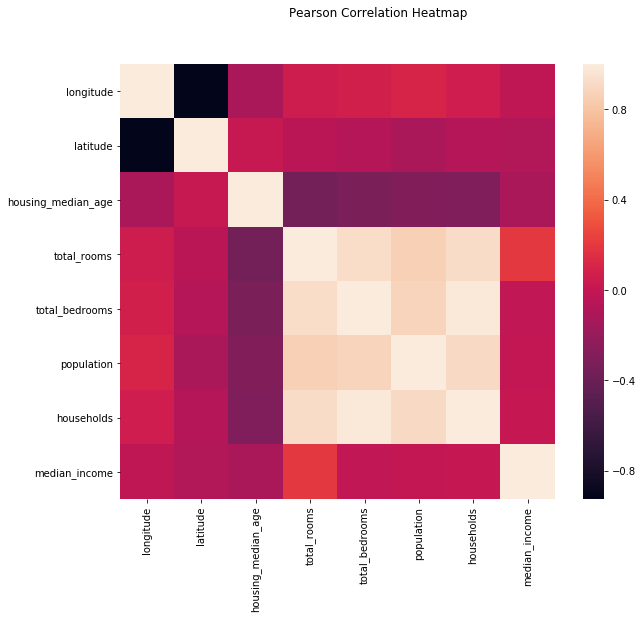

In [7]:
import seaborn as sns
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['median_house_value'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

从上述相关系数矩阵的热力图中可知,total_rooms ,total_bedrooms ,population ,households 这些变量相互之间都呈现出较强的正相关性,这是合理的,例如一个地区的人口数增加，那么该地区的房屋总数、卧室总数，住户数量都会增加,反之亦然。少部分变量呈现较强的负相关，经纬度之间是完全负相关，除此之外其他变量都呈现出教弱的正相关性和较弱的负相关性。

然后我们查看特征变量和目标变量之间的相关性：

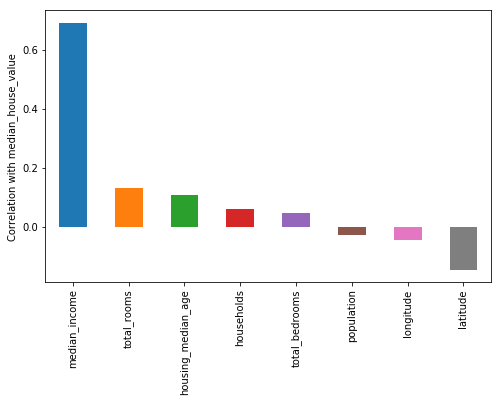

In [8]:
corr_with_median_house_value = df.corr()["median_house_value"].sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.ylabel('Correlation with median_house_value')
corr_with_median_house_value.drop("median_house_value").plot.bar()
plt.show();

从上图中可以看出收入的中位数(median_income)与我们的目标变量有较强的正相关性，这应该也是合理的，因为收入越高的人买的房子的价格也应该是越高。纬度(latitude)与目标变量呈现较为明显的负相关，这应该也是合理的，因为从之前的散点图上观察可知,加州房价中位数较高的区域位于西海岸的旧金山和洛杉矶这两个城市周围,因此高房价地区应该位于加州的西南部，我们知道在地图上越往北纬度就越高，越往南纬度就越低,因此纬度和房价呈现负相关是合理的。

## 合成特征

total_rooms 和 population 特征都会统计指定街区的相关总计数据。

但是，如果一个街区比另一个街区的人口更密集，会怎么样？我们可以创建一个合成特征（即 total_rooms 与 population 的比例）来探索街区人口密度与房屋价值中位数之间的关系。

In [9]:
df["rooms_per_person"] =(df['total_rooms'] / df['population'])

接下来我们使用带有合成特征的新特征集再训练一下我们的XGBoost模型，看看用新特征集以后模型的表现如何

In [10]:
X = df.loc[:, df.columns !=  'median_house_value'] 
y = df.loc[:, df.columns == 'median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train=y_train/1000
y_test=y_test/1000

xgb_model2 = XGBRegressor()
xgb_model2.fit(X_train, y_train, verbose=False)

y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_pred2,y_test))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.7468112469688724
Test r2 score:  0.7262306354625128
Train RMSE: 50.6259
Test RMSE: 52.0272


从上面的预测结果来看,使用了新的合成特征以后，test集上的RMSE从之前初步预测的54.1574降到了52.0272 ，新的合成特征集已经其作用了。

# 纬度分桶

对应经纬度这样数据，在做特征工程时我们需要将它做分桶(分箱)处理,所谓分桶处理就是将经度或维度分解成若干个区间。我们先看一下维度与目标变量的数据分布:

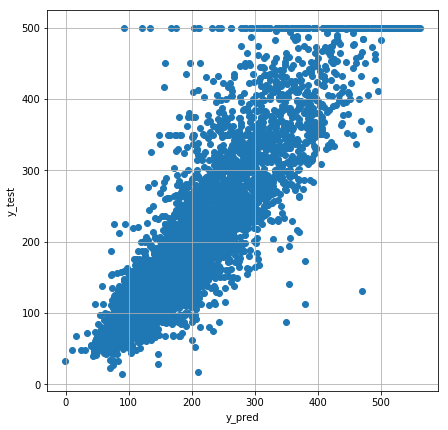

In [11]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.ylabel("y_test")
plt.xlabel("y_pred")
plt.scatter(y_pred2, y_test)
plt.show()

count    17000.00
mean        35.63
std          2.14
min         32.54
25%         33.93
50%         34.25
75%         37.72
max         41.95
Name: latitude, dtype: float64


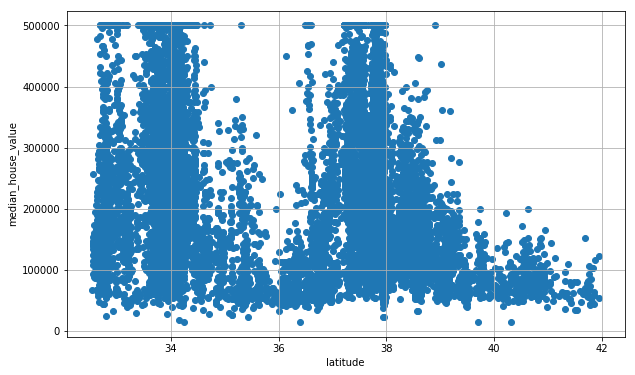

In [12]:
print(df.latitude.describe())
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('latitude')
plt.ylabel('median_house_value')
plt.scatter(df["latitude"], df["median_house_value"])

从维度的分布上来看，不同的维度对房价中位数较为敏感。因此我们可以将维度分解成若干个区间，这里我们可以将维度分解成32至42之间的10个区间,（例如 latitude_32_to_33、latitude_33_to_34 等）,经过分桶处理以后,维度将以one-hot的形式进行存储。

In [13]:
X = df.loc[:, df.columns !=  'median_house_value'] 
y = df.loc[:, df.columns == 'median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train=y_train/1000
y_test=y_test/1000


LATITUDE_RANGES = zip(range(32, 42), range(33, 43))
for r in LATITUDE_RANGES:
    X_train["lat_%d_to_%d" % r] = X_train["latitude"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)


    
LATITUDE_RANGES = zip(range(32, 42), range(33, 43))
for r in LATITUDE_RANGES:
    X_test["lat_%d_to_%d" % r] = X_test["latitude"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)

X_train = X_train.loc[:,X_train.columns !=  'latitude']    
X_test = X_test.loc[:,X_test.columns !=  'latitude']

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
xgb_model3 = XGBRegressor()
xgb_model3.fit(X_train, y_train, verbose=False)

y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_pred3,y_test))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

Train r2 score:  0.6579472187313906
Test r2 score:  0.6305524032126166
Train RMSE: 56.3485
Test RMSE: 58.0219


 我们发现经过对维度进行分桶以后,模型的表现RMSE并未再次降低，反而有所上升。可见对特征进行分桶处理对XGBoost并没有太大的效果。

# 对人口分桶

count    17000.00
mean      1429.57
std       1147.85
min          3.00
25%        790.00
50%       1167.00
75%       1721.00
max      35682.00
Name: population, dtype: float64


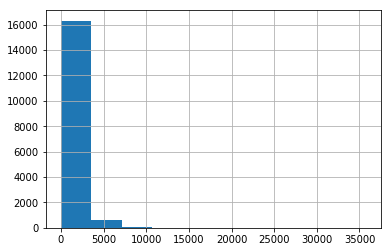

In [15]:
print(df.population.describe())
df.population.hist()

 绝大部分地区的人口都小于2500，个别地区人口超过35000，于是我们可以采用下面的规则来对人口进行分桶:

我们可以将 population 分为以下 3 个分桶：

* bucket_0 (< 5000)：对应于人口分布较少的街区
* bucket_1 (5000 - 25000)：对应于人口分布适中的街区
* bucket_2 (> 25000)：对应于人口分布较多的街区

In [16]:
X = df.loc[:, df.columns !=  'median_house_value'] 
y = df.loc[:, df.columns == 'median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train=y_train/1000
y_test=y_test/1000

for r in ((0,5000),(5000,25000),(25000,40000)):
    X_train["pop_%d_to_%d" % r] = X_train["population"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)
    
for r in ((0,5000),(5000,25000),(25000,40000)):
    X_test["pop_%d_to_%d" % r] = X_test["population"].apply(lambda l:1.0 if l>=r[0] and l<r[1] else 0.0)
    
X_train = X_train.loc[:,X_train.columns !=  'population']    
X_test = X_test.loc[:,X_test.columns !=  'population']

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [17]:
xgb_model4 = XGBRegressor()
xgb_model4.fit(X_train, y_train, verbose=False)

y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_pred4,y_test))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.7420620566580672
Test r2 score:  0.719851275863439
Train RMSE: 51.0597
Test RMSE: 52.5835


对人口进行分桶要比对维度进行分桶的效果要好很多,但是RMSE仍然略高于未分桶前的52.0272。

# 总结

今天我们尝试了几种之前没有使用过的特征工程的方法比如:特征合成和特征分桶。经过试验在我们这个数据集上使用特征合成的方法较为有效,而特征分桶效果并不理想。但这并不能说明特征分桶不是一个好的特征工程的方法，只能说明特征分桶对我们这个数据集或者对XGBoost效果不理想。不过我们可以在其他的数据集或者其他的回归模型上继续尝试特征分桶这个方法，至少在google的机器学习速成课程中使用特征分桶的效果还是挺好的，只不过和XGBoost相比要差一些。